In [ ]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [2]:
# Cell 2: Load dataset
df = pd.read_csv(r"D:\machine_learning\Airline_Delay_Cause.csv")


In [ ]:
# Cell 3: Impute missing values in numerical columns
imputer = SimpleImputer(strategy="mean")
cols_to_impute = df.select_dtypes(include=['float64']).columns
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])


['imputer.pkl']

In [ ]:
# Cell 4: Encode categorical variable
encoder = OneHotEncoder(sparse_output=False, drop="first")
carrier_encoded = encoder.fit_transform(df[['carrier']])
carrier_df = pd.DataFrame(carrier_encoded, columns=encoder.get_feature_names_out(['carrier']))
# Drop unnecessary columns and merge encoded data
df = df.drop(columns=['carrier', 'carrier_name', 'airport', 'airport_name']).join(carrier_df)


In [5]:
# Cell 5: Feature engineering
df['delay_ratio'] = df['arr_del15'] / df['arr_flights']
df['total_delay'] = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum(axis=1)


In [6]:
# Cell 6: Scale features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [7]:
# Cell 7: Reduce dimensions using PCA
pca = PCA(n_components=5)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=[f'pc{i+1}' for i in range(5)])

# Add target variable
df_pca['delayed'] = (df['arr_del15'] > 0).astype(int)

# Split data into features and target
X = df_pca.drop(columns=['delayed'])
y = df_pca['delayed']


In [8]:
# Cell 8: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)


In [9]:
# Cell 9: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [10]:
# Cell 10: Take a small sample (10%) of the training data for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train_balanced, y_train_balanced, train_size=0.1, random_state=42)


In [11]:
# Cell 11: Define parameter grid for RandomizedSearch
param_grid = {
     'n_estimators': [100, 200, 500],
     'max_depth': [10, 20, 30, None]
}

In [12]:
# Cell 12: Initialize Random Forest model
model = RandomForestClassifier()


In [ ]:
# Cell 13: Perform RandomizedSearchCV
randomized_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=42)
randomized_search.fit(X_sample, y_sample)

# Print best parameters
print("Best Parameters:", randomized_search.best_params_)


In [ ]:
# Cell 14: Train the final model with best parameters on full dataset
best_model = RandomForestClassifier(**randomized_search.best_params_)
best_model.fit(X_train_balanced, y_train_balanced)

print("Model Trained Successfully on Full Data! 🎉")


Model Trained Successfully on Full Data! 🎉


In [ ]:
# Cell 15: Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"RandomForest Accuracy: {accuracy:.2%}")
print("Classification Report:\n", classification_report(y_test, y_pred))


RandomForest Accuracy: 98.97%
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.83      1774
           1       1.00      0.99      0.99     61830

    accuracy                           0.99     63604
   macro avg       0.88      0.96      0.91     63604
weighted avg       0.99      0.99      0.99     63604



In [ ]:
# Cell 16: Train XGBoost model with best parameters
xgb_model = XGBClassifier(n_estimators=800, max_depth=30, n_jobs=-1, eval_metric="logloss")
xgb_model.fit(X_train_balanced, y_train_balanced)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
# Cell 17: Make predictions using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"🔥 XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_xgb))
joblib.dump(X_train.columns, "train_columns.pkl")  # حفظ أعمدة التدريب

🔥 XGBoost Accuracy: 99.02%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1774
           1       1.00      0.99      0.99     61830

    accuracy                           0.99     63604
   macro avg       0.89      0.95      0.92     63604
weighted avg       0.99      0.99      0.99     63604



['train_columns.pkl']

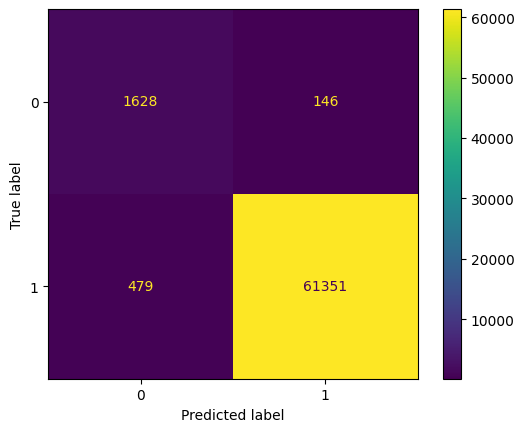

In [ ]:
# Cell 18: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [17]:
# Save model and preprocessing components
# Save all components
joblib.dump(model, 'flight_delay_model.pkl')  # Trained model
joblib.dump(imputer, 'imputer.pkl')          # Missing value imputer
joblib.dump(encoder, 'encoder.pkl')          # Categorical encoder
joblib.dump(scaler, 'scaler.pkl')            # Feature scaler
joblib.dump(pca, 'pca.pkl')                  # PCA transformer
joblib.dump(X_train.columns.tolist(), 'train_columns.pkl')  # Training columns

print("✅ Saved successfully!")

✅ Saved successfully!
